## Some exploratory data analysis and the development of vegetation dependent angle model

authors: Tuguldur Sukhbold

In [1]:
datapath = '../d/'

import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import product as iterp
from math import sin, cos, radians, pi
from sklearn.metrics import mean_absolute_error
from skimage.transform import warp_polar
from skimage.io import imread as rdtif

np.random.seed(123)

train = pd.read_csv(f'{datapath}train-unique.csv')
etrain = pd.read_csv(f'{datapath}extra_train.csv')
#train = pd.concat([train, etrain], ignore_index=True)

Text(0, 0.5, 'PDF')

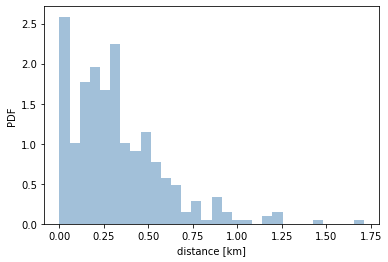

In [2]:
psz = train.PlotSize_acres

x, y = train.x, train.y
d = np.sqrt(x*x + y*y)

plt.hist(d, density=True, color='steelblue', alpha=0.5, bins=30)
plt.xlabel('distance [km]')
plt.ylabel('PDF')

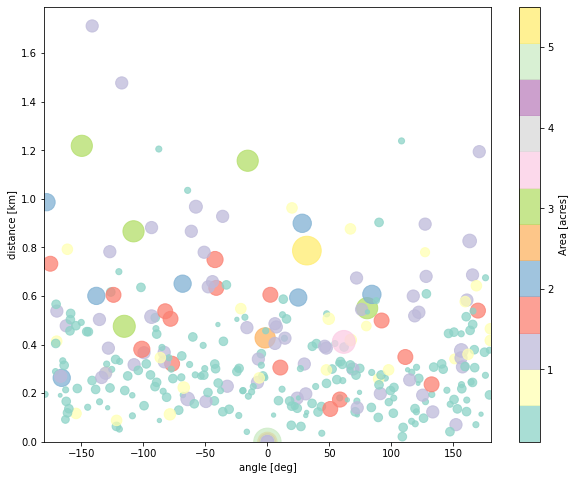

In [3]:
adeg = np.rad2deg(np.arctan2(y, x))
arad = np.arctan2(y, x)

plt.figure(figsize=(10,8))
plt.scatter(adeg, d, c=psz, s=psz*150, cmap='Set3', alpha=0.75)
plt.xlabel('angle [deg]')
plt.ylabel('distance [km]')
plt.ylim(0,1.79)
plt.xlim(-180, 180)
plt.colorbar(label='Area [acres]')

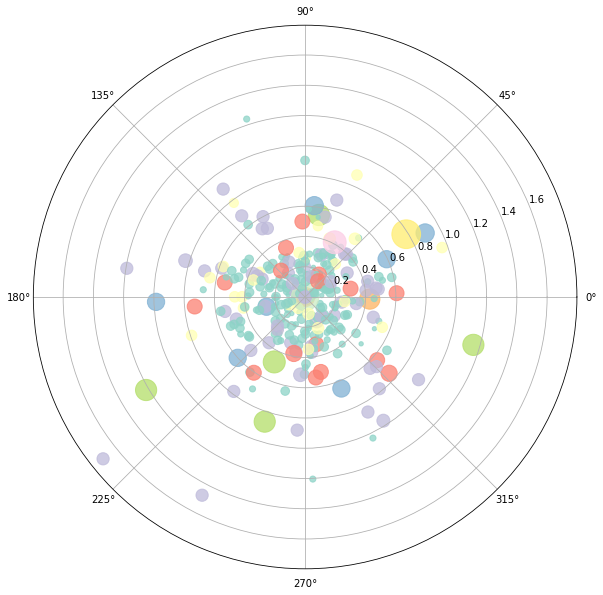

In [4]:
fig = plt.figure(figsize=(12,10))
ax  = fig.add_subplot(projection='polar')
c   = ax.scatter(arad, d, c=psz, s=psz*150, cmap='Set3', alpha=0.75)

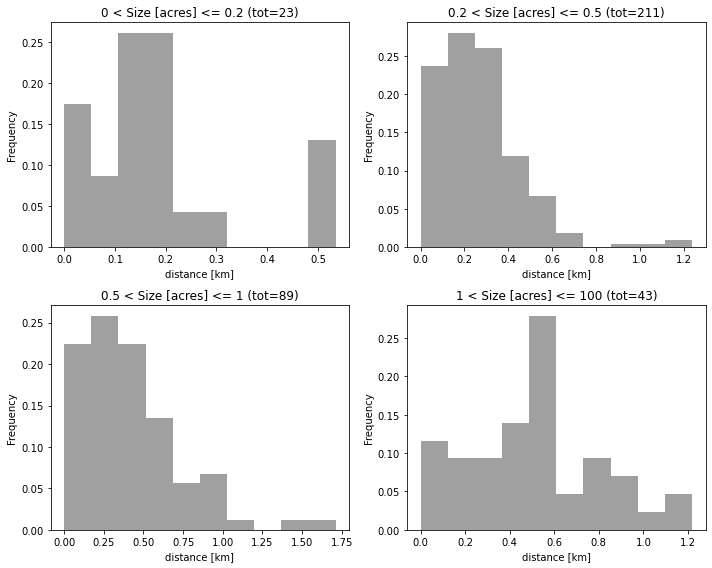

In [5]:
def mkFreqHist(ax, df, rng):
    x, y = df.x, df.y
    d    = np.sqrt(x*x + y*y)
    w    = np.ones_like(d) / len(d)
    ax.hist(d, weights=w, color='gray', alpha=0.75, bins=10)
    ax.set_xlabel('distance [km]')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{rng[0]} < Size [acres] <= {rng[1]} (tot={len(d)})')

    

rngs = [(0, 0.2), (0.2, 0.5), (0.5, 1), (1, 100)]
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,8), tight_layout=True)
k = 0
for i,j in iterp(range(2), range(2)):
    subdf = train.loc[(train.PlotSize_acres > rngs[k][0]) & (train.PlotSize_acres <= rngs[k][1])]
    mkFreqHist(axes[i,j], subdf, rngs[k])
    k += 1

## 2. Models checked on train set

In [6]:
def getSentinelTimeData(path2tif, filterCloudy=True):
    """
    process input Sentinel TIFF file to map its contents into a dictionary
    with filter keys and monthly images as values
    
    note: it won't process images with number of channels other than 192
    
    when filterCloudy flag is True:
    - excludes cloudy images based on cloud-mask (filter#16)
    - final dictionary contains 13 real filter data
    """
    
    # filter and month IDs
    filters = np.arange(16, dtype=int) + 1
    months  = np.arange(12) + 1

    # read TIFF file into 3D array
    img = rdtif(path2tif)
    
    # stop if its a funky image, proceed only if there are usual 192 channels:
    if img.shape[-1] != 192: exit(f' cannot process this funky image with {img.shape[-1]} channels')
    
    # initialize the dict with empty list for each filter
    d = {}
    for f in filters: d[f] = []
    
    # populate with 2D images
    for i, j in iterp(months, filters):

        channel = (i - 1) * len(filters) + j - 1
        
        # append normalized image
        maxFrame = np.amax(img[:, :, channel])
        if maxFrame == 0.:
            d[j].append(img[:, :, channel])
        else:
            d[j].append(img[:, :, channel] / maxFrame)
    
    # exclude cloudy images
    if filterCloudy:
        
        for f in filters:
            for month in months:
                
                # max value of cloud mask image
                maxCloudMask = np.amax(d[16][month-1])
                
                # its cloudy if max is not 0
                if maxCloudMask != 0: d[f][month-1] = None
        
        # we don't need the last 3 elements
        del d[16] # cloudmask itself
        del d[15] # QA20
        del d[14] # QA10

    return d


def getIndex(d, ID):
    l = []
    for m in range(len(d[1])):
        if d[1][m] is None:
            indx = None
        else:
            if ID == 'NDVI': indx = (d[7][m] - d[4][m]) / (d[7][m] + d[4][m])
            if ID == 'TBWI': indx = (d[10][m] - d[12][m]) / d[11][m]
        
        l.append(indx)                

    return l


def getVegFreq(img):
    radius = int(len(img) / 2)
    polar  = warp_polar(img, radius=radius).T
    freq   = np.array([sum(polar[:, i]) for i in range(max(polar.shape))])
    return freq / np.sum(freq)


def getSampleF4(dS):
    NDVI= getIndex(dS, ID = 'NDVI')
    if dS[4][6] is not None:
        sample = dS[4][6]
        k = 6
    elif dS[4][5] is not None:
        sample = dS[4][5]
        k=5
    else:
        for i in range(3,12):
            print(i, type(dS[4][i]))
            if dS[4][i] is not None:
                sample = dS[4][i]
                k=i
                break
    return sample, NDVI[k]


def getPszRange(szval, qual, realTest=False):
    if not realTest:
        rng = (0, 0.2)
        if qual == 3:
            if szval > 0.2 and szval <= 0.5: rng = (0.25, 0.5)
            if szval > 0.5 and szval <= 1.0: rng = (0.5,  1)
            if szval > 1:                    rng = (1,    100)
    
    else: # assume always bad quality in realTest
        rng = (0, 0.2)
        
    return rng


def getPszRange_Test():        
    return (0, 0.2)


def getDistance(rng):
    sdf   = train.loc[(train.PlotSize_acres > rng[0]) & (train.PlotSize_acres <= rng[1])]
    x, y  = sdf.x, sdf.y
    d     = np.sqrt(x*x + y*y)
    w     = np.ones_like(d) / len(d)
    return np.random.choice(d, p=w)


def getXY(d, adeg):
    """
    (x,y) displacements in [km] based on distance (d[km]) and angle (adeg[degrees])
    """
    arad = pi / 2 - radians(adeg)
    return d * cos(arad)/2, d * sin(arad)/2


def getScore(x,y, M_x, M_y):
    """
    MAE score based on test (x,y) and predicted (M_x, M_y)
    """
    tst  = np.vstack((x, y))
    pred = np.vstack((M_x, M_y))
    return mean_absolute_error(tst, pred)

### 2.1 Zeros and Means

Here all (x,y) predictions are set to all zeros or all mean values; these scores will be used as our benchmark:

In [7]:
M_x, M_y    = np.zeros(len(x)), np.zeros(len(y))
zeros_score = getScore(x, y, M_x, M_y)

M_x         = np.zeros(len(x)) + np.mean(x)
M_y         = np.zeros(len(y)) + np.mean(y)
means_score = getScore(x, y, M_x, M_y)

print(f' zeros: {zeros_score:.4f}     means: {means_score:.4f}')

 zeros: 0.2022     means: 0.2049


### 2.2 Uniform Angle and Exact Distances

Here the angles are drawn randomly from uniform, and distances from the exact training distribution:

In [8]:
M_adeg = np.random.uniform(low=-180, high=180, size=(len(train), ))

M_d = np.zeros(len(train))
for i in range(len(train)):
    rng    = getPszRange(train.PlotSize_acres[i], train.Quality[i])
    M_d[i] = getDistance(rng)

M_x, M_y = np.zeros(len(M_d)), np.zeros(len(M_d))
for i in range(len(M_adeg)): M_x[i], M_y[i] = getXY(M_d[i], M_adeg[i])

[Text(0, 0.5, 'model y-component [km]'), Text(0.5, 0, 'test y-component [km]')]

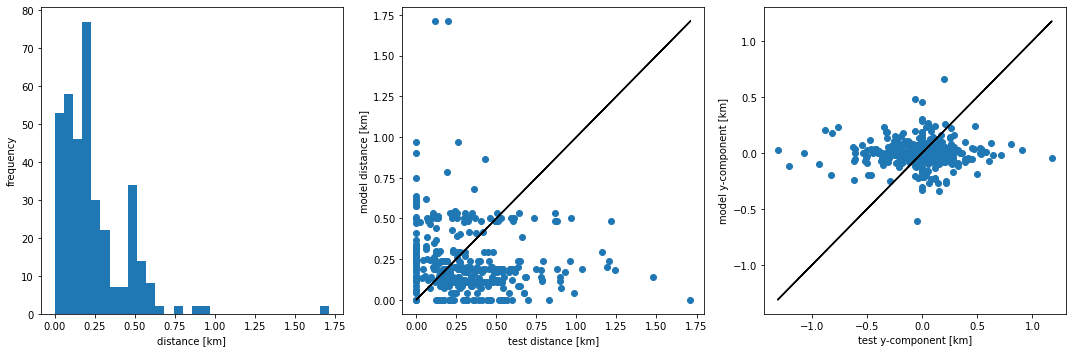

In [9]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5), tight_layout=True)
ax[0].hist(M_d, bins=30)
ax[0].set(ylabel='frequency', xlabel='distance [km]')
ax[1].scatter(d, M_d)
ax[1].plot(d,d, color='black')
ax[1].set(ylabel='model distance [km]', xlabel='test distance [km]')
ax[2].scatter(y, M_y)
ax[2].plot(y,y, color='black')
ax[2].set(ylabel='model y-component [km]', xlabel='test y-component [km]')

In [10]:
getScore(x,y, M_x, M_y)

0.23065706555304355

### 2.3 Uniform Angle and Uniform Limited Distances

Here the angles are still drawn randomly from uniform, but the distances are now draw from a limited uniform in the range [0, 0.25] km:

In [11]:
M_adeg = np.random.uniform(low=-180, high=180, size=(len(train), ))
M_d    = np.random.uniform(low=0, high=0.25, size=(len(train), ))

M_x, M_y = np.zeros(len(M_d)), np.zeros(len(M_d))
for i in range(len(M_adeg)): M_x[i], M_y[i] = getXY(M_d[i], M_adeg[i])

[Text(0, 0.5, 'model y-component [km]'), Text(0.5, 0, 'test y-component [km]')]

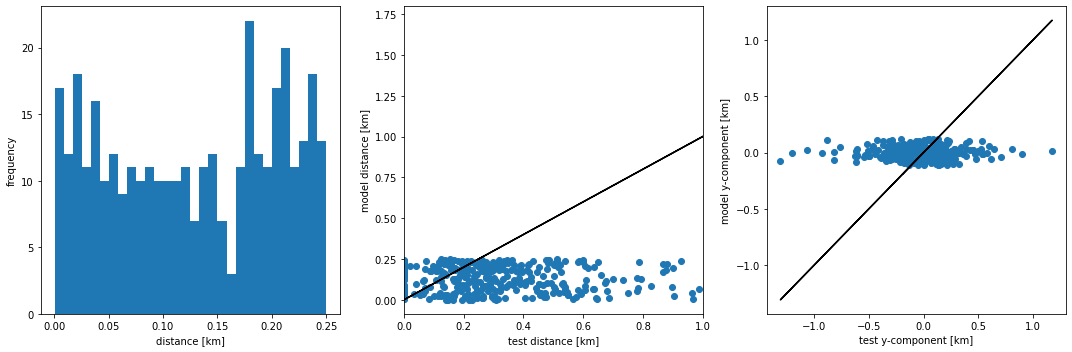

In [12]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5), tight_layout=True)
ax[0].hist(M_d, bins=30)
ax[0].set(ylabel='frequency', xlabel='distance [km]')
ax[1].scatter(d, M_d)
ax[1].plot(d,d, color='black')
ax[1].set(ylabel='model distance [km]', xlabel='test distance [km]', xlim=[0,1])
ax[2].scatter(y, M_y)
ax[2].plot(y,y, color='black')
ax[2].set(ylabel='model y-component [km]', xlabel='test y-component [km]')

In [13]:
getScore(x,y, M_x, M_y)

0.20978312523191903

### 2.4 Vegetation Dependent Angle and Uniform Limited Distances

Now the angles are drawn from a distribution based on the vegetation map of Sentinel-2 images. The distances are still draw from a limited uniform in the range [0, 0.25] km:

In [14]:
fieldID = 'a5e136b4'
img     = rdtif(f'{datapath}sentinel/{fieldID}.tif')
dS      = getSentinelTimeData(f'{datapath}sentinel/{fieldID}.tif')
dS[4][6] is None

True

In [15]:
M_adeg = np.array([])
M_d    = np.array([])
M_x    = np.array([])
M_y    = np.array([])
x,y    = np.array([]), np.array([])

for i in range(len(train)):
    fieldID = train.ID[i].split('_')[-1]    
    img     = rdtif(f'{datapath}sentinel/{fieldID}.tif')
    
    if img.shape[-1] == 192:
        dS      = getSentinelTimeData(f'{datapath}sentinel/{fieldID}.tif')
        
        # normalized mask
        sampleF4, NDVI = getSampleF4(dS)
        img     = sampleF4 * NDVI - NDVI
        img     = img + abs(np.amin(img))
        img     = img / np.amax(img)
        img[img > 0.5] = 0
        img[img > 0]   = 1
        
        # draw angle based on vegetation probability
        probV   = getVegFreq(img)        
        adeg    = np.random.choice(np.arange(360)-180, p=probV)
        M_adeg  = np.append(M_adeg, adeg)
        
        # random distance
        dval    = np.random.uniform(low=0, high=0.25)
        M_d     = np.append(M_d, dval)
        
        # model x,y
        xval, yval = getXY(dval, adeg)
        M_x     = np.append(M_x, xval)
        M_y     = np.append(M_y, yval)
        
        # corresponding test x,y
        x       = np.append(x, train.x[i])
        y       = np.append(y, train.y[i])

In [16]:
getScore(x,y, M_x, M_y)

0.22224544851809966

[Text(0, 0.5, 'model y-component [km]'), Text(0.5, 0, 'test y-component [km]')]

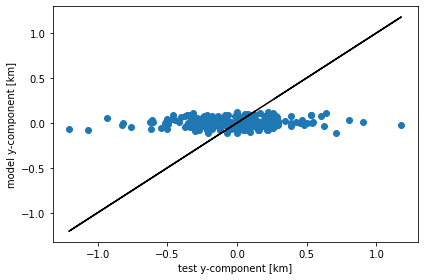

In [17]:
fig, ax = plt.subplots(tight_layout=True)
ax.scatter(y, M_y)
ax.plot(y,y, color='black')
ax.set(ylabel='model y-component [km]', xlabel='test y-component [km]')

## Test and Submission

In [18]:
test   = pd.read_csv(f'{datapath}test.csv')

np.random.seed(0)

M_x    = np.array([])
M_y    = np.array([])

for i in range(len(test)):
    fieldID = test.ID[i].split('_')[-1]    
    img     = rdtif(f'{datapath}sentinel/{fieldID}.tif')
    
    if img.shape[-1] == 192:
        dS      = getSentinelTimeData(f'{datapath}sentinel/{fieldID}.tif')
        
        # normalized mask
        sampleF4, NDVI = getSampleF4(dS)
        img     = sampleF4 * NDVI - NDVI
        img     = img + abs(np.amin(img))
        img     = img / np.amax(img)
        img[img > 0.5] = 0
        img[img > 0]   = 1
        
        # draw angle based on vegetation probability
        probV   = getVegFreq(img)        
        adeg    = np.random.choice(np.arange(360)-180, p=probV)
        
        # random distance
        dval    = np.random.uniform(low=0.1, high=0.25)
        
        # model x,y
        xval, yval = getXY(dval, adeg)
        M_x     = np.append(M_x, xval)
        M_y     = np.append(M_y, yval)
    
    else:
        M_x = np.append(M_x, 0.0)
        M_y = np.append(M_y, 0.0)
        


3 <class 'numpy.ndarray'>
3 <class 'numpy.ndarray'>
3 <class 'numpy.ndarray'>
3 <class 'numpy.ndarray'>
3 <class 'NoneType'>
4 <class 'numpy.ndarray'>
3 <class 'numpy.ndarray'>
3 <class 'numpy.ndarray'>


In [19]:
submit = pd.read_csv(f'{datapath}sample_submission.csv')

submit.x = M_x
submit.y = M_y

submit.head()

,ID,x,y
0,id_e7032b10,0.010833,0.103071
1,id_ae7cb51e,-0.090742,0.004756
2,id_e59f7730,-0.091274,-0.036877
3,id_b9011c86,-0.047541,0.106778
4,id_caaeb9f8,0.038183,-0.068883


In [20]:
submit.to_csv('limRange_SentinelDepAngle_submission.csv', index=False)

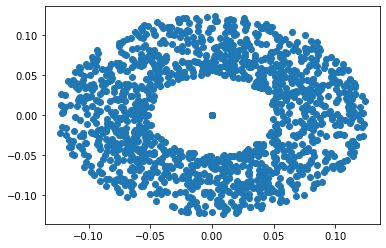

In [21]:
plt.scatter(M_x, M_y)

### Zeros and Means

In [22]:
train  = pd.read_csv(f'{datapath}train-unique.csv')
                     
submit = pd.read_csv(f'{datapath}sample_submission.csv')

submit.x = 0
submit.y = 0

submit.to_csv('zeros_submission.csv', index=False)

submit.x = np.mean(train.x)
submit.y = np.mean(train.y)

submit.to_csv('means_submission.csv', index=False)

submit.head()

,ID,x,y
0,id_e7032b10,-0.016858,-0.015343
1,id_ae7cb51e,-0.016858,-0.015343
2,id_e59f7730,-0.016858,-0.015343
3,id_b9011c86,-0.016858,-0.015343
4,id_caaeb9f8,-0.016858,-0.015343
